In [ ]:
!pip install torch==2.5.0 torchvision --index-url https://download.pytorch.org/whl/cpu

# 1. Setting Up

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, random_split, Dataset

import numpy as np
import cv2
import os
import random
import matplotlib.pyplot as plt


import torchvision.transforms.v2 as T
from torchvision.models.segmentation import deeplabv3_resnet50
from torchvision.models import resnet50, ResNet50_Weights

# For bounding box manipulations (if needed)
from torchvision.ops import box_convert, box_iou

# If using Albumentations for data augmentations
# pip install albumentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# If you want to use a CRF post-processing library or morphological ops
# pip install pydensecrf, opencv-python, etc.
# import pydensecrf.densecrf as dcrf

# Import the dataloader with images and bounding boxes for CAM generation
from DatasetLoad import get_dataloader

100%|██████████| 792M/792M [00:30<00:00, 26.1MB/s]
100%|██████████| 19.2M/19.2M [00:01<00:00, 11.7MB/s]


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Load the Oxford-IIIT Pet Dataset (Classification Labels)

We only need image–class pairs, so we use:

In [ ]:
from torchvision.datasets import OxfordIIITPet

# Define transforms
train_transform = T.Compose([
    T.Resize((256, 256)),
    T.RandomResizedCrop((224, 224), scale=(0.8, 1.0)),
    T.RandomHorizontalFlip(p=0.5),
    T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


# Custom wrapper to apply transform on-the-fly
class TransformDataset(Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        img, target = self.subset[idx]
        if self.transform:
            img = self.transform(img)
        return img, target

# Load dataset without transform first
base_dataset = OxfordIIITPet(
    root="./oxford_iiit_data",
    download=True,
    target_types="category",  # classification labels only
    split="trainval",
    transform=None,
)

# Train/val split
train_size = int(0.85 * len(base_dataset))
val_size = len(base_dataset) - train_size
train_subset, val_subset = random_split(base_dataset, [train_size, val_size])

# Wrap subsets with respective transforms
train_ds = TransformDataset(train_subset, train_transform)
val_ds = TransformDataset(val_subset, val_transform)

# Data loaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=2)

num_classes = 37  # There are 37 pet breeds

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


## 3. Model Initialization (Classifier)

Pre-trained ResNet50 for classification.

In [ ]:
def get_resnet50_classifier_model(num_classes=37, pretrained=True):
    """
    Oxford-IIIT has 37 categories (pet breeds) for classification.
    """
    if pretrained:
      model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
    else:
      model = resnet50()

    # Replace the final FC layer
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    return model

## 4. Training the Classifier

We’ll include:
  *	Learning rate scheduling (StepLR as an example)
  *	Weight decay
  *	Gradient clipping

In [ ]:
def train_classifier(model, train_loader, val_loader,
                     num_epochs=10, lr=1e-3,
                     weight_decay=1e-4, clip_grad_norm=None, save_path="classifier.pth"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = StepLR(optimizer, step_size=5, gamma=0.1)  # example scheduler

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:  # bboxes not loaded into train loader so not used in training here
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()

            # Gradient clipping
            if clip_grad_norm is not None:
              torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_grad_norm)

            optimizer.step()
            running_loss += loss.item() * images.size(0)

        scheduler.step()

        epoch_loss = running_loss / len(train_loader.dataset)
        val_acc = evaluate_classifier(model, val_loader, device)

        print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {epoch_loss:.4f} | Val Acc: {val_acc:.4f}")


    # SAVE the classifier model after training
    torch.save(model.state_dict(), save_path)
    print(f"Classifier model saved to {save_path}")

    return model

def evaluate_classifier(model, val_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

## 5. Generating Raw CAMs (Grad-CAM)

A straightforward Grad-CAM approach:

In [ ]:
class GradCAM:
    """
    Simple Grad-CAM for ResNet-based networks.
    """
    def __init__(self, model, target_layer_name="layer4"):
        self.model = model
        self.model.eval()

        # Hook the target layer
        self.target_layer = None
        for name, module in self.model.named_children():
            if name == target_layer_name:
                self.target_layer = module
                break

        if self.target_layer is None:
            raise ValueError(f"Layer {target_layer_name} not found in model")

        self.gradients = None
        self.activations = None

        def forward_hook(module, input, output):
            self.activations = output

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0]

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def __call__(self, x, class_idx=None):
        """
        x: input image tensor of shape [B, C, H, W]
        class_idx: which class index to compute CAM for. If None, uses argmax
        Returns: CAM for each image in the batch
        """
        logits = self.model(x)  # forward pass
        if class_idx is None:
            class_idx = torch.argmax(logits, dim=1)

        # Compute gradients w.r.t. target class
        one_hot = torch.zeros_like(logits)
        for i in range(logits.size(0)):
            one_hot[i, class_idx[i]] = 1.0

        self.model.zero_grad()
        logits.backward(gradient=one_hot, retain_graph=True)

        gradients = self.gradients  # [B, C, H', W']
        activations = self.activations  # [B, C, H', W']

        # Global-average-pool the gradients
        weights = torch.mean(gradients, dim=(2, 3), keepdim=True)  # [B, C, 1, 1]

        # Weighted sum of activations
        cams = (weights * activations).sum(dim=1, keepdim=True)  # [B, 1, H', W']

        # ReLU
        cams = F.relu(cams)

        # Normalize each CAM to [0,1]
        cams = cams - cams.view(cams.size(0), -1).min(dim=1)[0].view(cams.size(0),1,1,1)
        cams = cams / (cams.view(cams.size(0), -1).max(dim=1)[0].view(cams.size(0),1,1,1) + 1e-8)

        return cams

**Bounding Box Usage:**
  *	Bounding box expansion helps ensure that most of the pet is inside the bounding box.
  *	Soft weighting ensures that if there’s any part of the pet outside that expanded box, you don’t completely discard it (i.e., zero it out). Instead, you downweight it, but you still keep it if the model strongly activates there.

In [ ]:
def expand_bbox(bbox, expansion_ratio=1.5, img_w=224, img_h=224):
    """
    Expand the bounding box by 'expansion_ratio' while staying within [0, img_w]x[0, img_h].
    bbox: (x_min, y_min, x_max, y_max)
    expansion_ratio: e.g., 1.5 -> 50% bigger in width/height each side.
    """
    x_min, y_min, x_max, y_max = bbox

    # Current width/height
    box_w = x_max - x_min
    box_h = y_max - y_min

    # Expansion amount
    dw = (box_w * (expansion_ratio - 1)) / 2.0
    dh = (box_h * (expansion_ratio - 1)) / 2.0

    # Center-based expansion
    cx = 0.5 * (x_min + x_max)
    cy = 0.5 * (y_min + y_max)

    new_xmin = max(0, int(cx - (box_w/2 + dw)))
    new_xmax = min(img_w, int(cx + (box_w/2 + dw)))
    new_ymin = max(0, int(cy - (box_h/2 + dh)))
    new_ymax = min(img_h, int(cy + (box_h/2 + dh)))

    return (new_xmin, new_ymin, new_xmax, new_ymax)

def apply_expanded_bbox_soft_weights(cam, bbox, H, W,
                                     expansion_ratio=1.5,
                                     inside_weight=0.9,
                                     outside_weight=0.3):
    """
    1) Expand the bounding box by 'expansion_ratio'.
    2) Apply soft weighting inside vs. outside the expanded box.
       - inside_weight = 0.9
       - outside_weight = 0.3 (or any fraction you want)
    """
    # Expand the bbox
    x_min, y_min, x_max, y_max = expand_bbox(bbox, expansion_ratio, img_w=W, img_h=H)

    # Create a weight map
    weights = np.full((H, W), outside_weight, dtype=np.float32)
    weights[y_min:y_max, x_min:x_max] = inside_weight

    return cam * weights

def generate_cams(model, data_loader, gradcam, device,
                  apply_bbox=True, output_dir="cams_out"):
    """
    Generate and save CAMs.
    We'll upsample the CAM to the original image size,
    then optionally mask it with the bounding box.
    """
    os.makedirs(output_dir, exist_ok=True)

    model.eval()
    gradcam.model.eval()

    #idx = 0  # for unique file naming
    with torch.no_grad():
        for batch_idx, (images, targets, paths) in enumerate(data_loader):
            # images shape: [B, C, H, W]
            images = images.to(device)

            # You need a class index to call gradcam(..., class_idx=label)
            # If you have exactly one label per image, do something like:
            # (assuming the target is detection style but you only want label[0])
            class_idxs = []
            for t in targets:
                # If there's exactly 1 label per image
                class_idxs.append(t["labels"][0])

            class_idxs = torch.tensor(class_idxs, dtype=torch.long, device=device)

            # GradCAM call needs a forward and backward pass,
            # so let's do it with requires_grad
            with torch.enable_grad():
                cams_batch = gradcam(images, class_idx=class_idxs)


            # cams_batch shape: [B, 1, H', W']
            # Upsample CAM to match input size (e.g. 224x224 if that's your input transform)
            # using bilinear interpolation
            upsampled_cams = F.interpolate(cams_batch, size=(images.shape[2], images.shape[3]),
                                           mode='bilinear', align_corners=False)

            # Now upsampled_cams is [B, 1, H, W]
            upsampled_cams = upsampled_cams.squeeze(1).cpu().numpy()  # shape [B, H, W]

            # If original images are bigger than 224, you may have to re-scale bounding boxes and
            # possibly re-scale the CAM again. This depends on your transformations.

            # Loop over each image in the batch
            for b in range(len(images)):
                cam_2d = upsampled_cams[b]

                if apply_bbox:
                    # bboxes[b] is the bounding box for this image in original scale
                    # Make sure the scale is consistent with your input size!

                    # We might have multiple boxes. Suppose we only want box 0:
                    bbox = targets[b]["boxes"][0]  # shape [4]
                    # If needed, convert to numpy
                    bbox = bbox.cpu().numpy()

                    cam_2d = apply_expanded_bbox_soft_weights(
                                cam_2d,
                                bbox,
                                H=cam_2d.shape[0],
                                W=cam_2d.shape[1],
                                expansion_ratio=1.5,
                                inside_weight=1.0,
                                outside_weight=0.3
                            )

                # Build a filename from the image path
                base_name = os.path.splitext(os.path.basename(paths[b]))[0]
                cam_file = f"{base_name}_cam.npy"
                cam_path = os.path.join(output_dir, cam_file)

                # Save each CAM
                # cam_path = os.path.join(output_dir, f"cam_{idx}.npy")
                np.save(cam_path, cam_2d)
                #idx += 1

    print("CAM generation complete!")

## 6. Apply ReCAM (Refinement / Expansion)

Below is an illustrative approach inspired by the ReCAM paper. This usually involves:
  *	Re-scoring the CAM to ensure more complete coverage of the object.
  *	Possibly iterative expansions (e.g. random erasing, multi-scale expansions).
  *	We show a simplified version that scales up smaller areas, and we add expansions.

In [ ]:
def recam_refinement(cam, expansion_factor=1.2, threshold=0.3):
    """
    Simplified approach:
    1. If the average of the top region is below a certain threshold,
       push it up (expand coverage).
    2. You could also do iterative random erasing or multi-scale expansions.
    """
    # cam: 2D np array [H, W] in [0,1]
    # Step 1: thresholding
    mask = (cam >= threshold).astype(np.uint8)
    coverage = mask.sum() / (cam.shape[0]*cam.shape[1])

    # If coverage < some ratio, inflate the activation
    if coverage < 0.1:
        cam = cam * expansion_factor
        cam = np.clip(cam, 0, 1)

    # Re-threshold
    return cam

def refine_cams_with_recam(cam_dir, refined_dir="cams_refined",
                           threshold=0.3, expansion_factor=1.2):
    os.makedirs(refined_dir, exist_ok=True)

    cam_files = [f for f in os.listdir(cam_dir) if f.endswith('.npy')]
    for cfile in cam_files:
        cam_path = os.path.join(cam_dir, cfile)
        cam = np.load(cam_path)

        refined_cam = recam_refinement(cam, expansion_factor, threshold)

        # Save
        refined_path = os.path.join(refined_dir, cfile)  # same base name
        np.save(refined_path, refined_cam)

    print("ReCAM refinement complete!")

## 7. Pseudo-Label Filtering

A simple approach:
* We binarize or do top-k%.
* For example, if we do a threshold t=0.5, anything above 0.5 = foreground, else background.

In [ ]:
def generate_pseudo_masks(refined_cam_dir, output_mask_dir="pseudo_masks", threshold=0.5):
    os.makedirs(output_mask_dir, exist_ok=True)

    cam_files = [f for f in os.listdir(refined_cam_dir) if f.endswith('.npy')]

    for cfile in cam_files:
        cam_path = os.path.join(refined_cam_dir, cfile)
        cam = np.load(cam_path)

        # Binarize
        pseudo_mask = (cam >= threshold).astype(np.uint8)

        # Save as PNG, for instance (Convert "myImage_cam.npy" -> "myImage_cam.png")
        mask_path = os.path.join(output_mask_dir, cfile.replace('.npy', '.png'))
        cv2.imwrite(mask_path, pseudo_mask*255)

    print("Pseudo-label generation complete!")

## 8. Train Segmentation Model (DeepLab V3+)
Now we use the generated pseudo masks as “ground truth” for training. We’ll assume you have a new dataset that loads:
  *	(Image, PseudoMask)
  *	Possibly ignoring bounding boxes at this stage.

Transforms:
Explanation
*	Resize(256, 256): Brings the image + mask to a consistent scale before further augmentations.
* RandomCrop(224, 224): Crops both the image + mask to 224×224 at the same random location.
* HorizontalFlip(p=0.5): Flips the image + mask horizontally 50% of the time.
* ColorJitter: Adjusts brightness, contrast, saturation, and hue of the image only. Albumentations automatically knows to skip these color transformations on the mask.
* Normalize: Normalizes the image using mean & std from ImageNet. The mask is unaffected.
* ToTensorV2: Converts both the image (float tensor in [C, H, W] with normalization) and the mask (uint8 or float tensor in [H, W]) to PyTorch tensors.

Different Transforms for Images vs. Masks?
* Geometric transforms (resize, flip, crop) must be applied equally to both the image and the segmentation mask. Otherwise, they would no longer be aligned.
* Color transforms should only be applied to the image—the mask is a label map, so color transformations don’t make sense. Albumentations handles that automatically: if you mark the mask as "mask", it only applies geometric transforms to the mask.
* Typically, you do not need separate pipelines for images and masks. You define a single Albumentations Compose with additional_targets={"mask": "mask"}, which ensures the correct behavior for both.

Hence, you do not build two separate transformations. Instead, you define one Albumentations pipeline that handles each item differently depending on whether it’s the "image" or "mask" key.


In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

seg_transform = A.Compose([
    # 1) Resize - to have a consistent baseline size
    A.Resize(224, 224),

    # Removed RandomCrop

    # 2) Horizontal Flip (50% chance)
    A.HorizontalFlip(p=0.5),

    # 3) Optional color augmentations that affect ONLY the image
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),

    # 4) Normalize the image (typical ImageNet stats)
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),

    # 5) Convert both image and mask to torch tensors
    ToTensorV2()
],
additional_targets={"mask": "mask"})

In [ ]:
import os

def build_img_mask_pairs(img_dir, mask_dir, img_paths):
    """
    Given the original list of image_paths (which you used in the dataset),
    build a (image_path, mask_path) list. We assume the mask is named:
      <image_basename>_cam.png
    in mask_dir.
    """
    pairs = []
    for ipath in img_paths:
        base_name = os.path.splitext(os.path.basename(ipath))[0]
        mask_name = f"{base_name}_cam.png"
        mask_path = os.path.join(mask_dir, mask_name)
        pairs.append((ipath, mask_path))
    return pairs

In [ ]:
class PseudoSegDataset(torch.utils.data.Dataset):
    def __init__(self, img_mask_pairs, transform=None):
        self.img_mask_pairs = img_mask_pairs # list of (image_path, mask_path)
        self.transform = transform

    def __len__(self):
        return len(self.img_mask_pairs)

    def __getitem__(self, idx):
        img_path, mask_path = self.img_mask_pairs[idx]

        # Load image
        image = cv2.imread(img_path)
        image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_LINEAR)    # Now image is guaranteed 224×224
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # if image is None:
        #   print(f"Image is None for {img_path}")
        # else:
        #   print(f"Image shape before transform for idx={idx}: {image.shape}")

        # Load pseudo mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)   # 0/255
        mask = (mask > 127).astype(np.uint8) # binarize as 0/1

        # if mask is None:
        #   print(f"Mask is None for {mask_path}")
        # else:
        #   print(f"Mask shape before transform for idx={idx}: {mask.shape}")

        if self.transform:
            # Albumentations expects 'image' and 'mask' in a dictionary
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"]

        return image, mask


def get_deeplab_v3(num_classes=2, pretrained=True):
    model = deeplabv3_resnet50(pretrained=pretrained)
    model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)  # output channels = 2 (background, foreground)
    return model

**Training loop for segmentation:** (Need to save weights)

In [ ]:
def train_segmentation_model(seg_model, seg_train_loader, seg_val_loader,
                            num_epochs=10, lr=1e-3, weight_decay=1e-4, save_path="weakly_segmentation.pth"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    seg_model = seg_model.to(device)

    optimizer = optim.Adam(seg_model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

    # For binary segmentation, we can use BCEWithLogitsLoss:
    criterion = nn.CrossEntropyLoss()  # if 2-class with integer mask[0 or 1]

    for epoch in range(num_epochs):
        seg_model.train()
        total_loss = 0

        for images, masks in seg_train_loader:
            images = images.to(device)
            masks = masks.long().to(device)  # ensure correct type for CE
            optimizer.zero_grad()

            outputs = seg_model(images)['out']  # DeepLab outputs a dict
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * images.size(0)

        scheduler.step()
        train_loss = total_loss / len(seg_train_loader.dataset)
        val_loss = evaluate_segmentation(seg_model, seg_val_loader, criterion, device)

        print(f"[{epoch+1}/{num_epochs}] Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


    # SAVE the segmentation model after training
    torch.save(seg_model.state_dict(), save_path)
    print(f"segmentation model saved to {save_path}")

    return seg_model

def evaluate_segmentation(seg_model, seg_val_loader, criterion, device):
    seg_model.eval()
    total_loss = 0
    with torch.no_grad():
        for images, masks in seg_val_loader:
            images = images.to(device)
            masks = masks.long().to(device)
            outputs = seg_model(images)['out']
            loss = criterion(outputs, masks)
            total_loss += loss.item() * images.size(0)

    return total_loss / len(seg_val_loader.dataset)

## 9. Post-Processing (Optional: CRF / Morphological Ops)

You can apply a dense CRF or morphological opening/closing to each predicted segmentation mask. Here is a simple morphological example:

In [ ]:
import cv2
import numpy as np

def morphological_refinement(pred_mask, kernel_size=3):
    """
    pred_mask: np.array of shape [H, W], values in {0,1}.
    """
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    # morphological closing -> remove small holes
    refined = cv2.morphologyEx(pred_mask, cv2.MORPH_CLOSE, kernel)
    return refined

**CRF usage typically looks like:**

In [ ]:
# Outline (not a fully functional snippet):
# def apply_crf(image, pred_mask_prob):
#     # Setup the dense CRF using pydensecrf
#     d = dcrf.DenseCRF2D(W, H, 2)  # 2 classes
#     # set unary potentials from the pred_mask_prob
#     # set pairwise potentials
#     # run inference
#     # return refined mask
#     pass

## 10. Evaluation on Segmentation Metrics

To evaluate, we typically compute mIoU or Dice on the ground-truth masks. For Oxford-IIIT, you have ground-truth segmentation masks. We can do something like:

In [ ]:
def compute_mIoU(pred_mask, gt_mask, num_classes=2):
    """
    pred_mask, gt_mask: [H, W] in {0,1} or {0,...,num_classes-1}
    For binary, it's 0 or 1.
    """
    # Flatten
    pred_flat = pred_mask.flatten()
    gt_flat = gt_mask.flatten()

    ious = []
    for c in range(num_classes):
        pred_inds = (pred_flat == c)
        gt_inds = (gt_flat == c)
        intersection = (pred_inds & gt_inds).sum()
        union = (pred_inds | gt_inds).sum()
        if union == 0:
            iou = 1 if intersection == 0 else 0
        else:
            iou = intersection / union
        ious.append(iou)
    return np.mean(ious)

def evaluate_on_test(seg_model, test_loader, device):
    seg_model.eval()
    all_ious = []
    with torch.no_grad():
        for images, masks in test_loader:
            images = images.to(device)
            outputs = seg_model(images)['out']
            # get predictions
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            # compare with ground truth
            for b in range(preds.shape[0]):
                pred_mask = preds[b]
                gt_mask = masks[b].numpy()
                iou = compute_mIoU(pred_mask, gt_mask, num_classes=2)
                all_ious.append(iou)
    return np.mean(all_ious)

# Main

In [ ]:
def main():
    # 1. Load your train/val data
    # from dataset_load import train_loader, val_loader  # custom
    # train_loader, val_loader = ...

    # 2. Create a classifier, train it
    # classifier = get_resnet50_classifier_model(num_classes=37,pretrained=True)
    # classifier = train_classifier(
    #     model=classifier,
    #     train_loader=train_loader,
    #     val_loader=val_loader,
    #     num_epochs=10, lr=1e-3, weight_decay=1e-4, clip_grad_norm=None, save_path="classifier.pth" )
    # If gradient clipping is needed we should assign a optimal clip_grad_norm value Ex: 5.0

    # Loading Classifier
    classifier = get_resnet50_classifier_model(num_classes=37,pretrained=False)
    classifier.load_state_dict(torch.load("/content/classifier.pth", map_location=device))
    classifier = classifier.to(device)


    # Load trainval dataset with Bounding Boxes
    train_loader_bbox, train_img_paths = get_dataloader()


    # 3. Generate raw CAMs
    gradcam = GradCAM(classifier, target_layer_name="layer4")  # for ResNet
    generate_cams(
        model=classifier,
        data_loader=train_loader_bbox,   # or a combined trainval loader if you want CAM for all
        gradcam=gradcam,
        device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
        apply_bbox=True,
        output_dir="cams_out"
    )

    # 4. Apply ReCAM refinement
    refine_cams_with_recam("cams_out", refined_dir="cams_refined",
                           threshold=0.3, expansion_factor=1.2)

    # 5. Generate pseudo masks
    generate_pseudo_masks(refined_cam_dir="cams_refined",
                          output_mask_dir="pseudo_masks",
                          threshold=0.5)

    # 6. Train a segmentation model (DeepLab) with these pseudo masks

    # Build a dataset from your images and "pseudo_masks"

    img_mask_pairs = build_img_mask_pairs(
    img_dir="/content/oxford_iiit_data/oxford-iiit-pet/images",
    mask_dir="pseudo_masks",
    img_paths=train_img_paths) # the same list used in the dataset

    seg_trainval_dataset = PseudoSegDataset(img_mask_pairs, transform=seg_transform)

    # Split dataset into train and val
    seg_train_size = int(0.85 * len(seg_trainval_dataset))
    seg_val_size = len(seg_trainval_dataset) - seg_train_size
    seg_train_ds, seg_val_ds = random_split(seg_trainval_dataset, [seg_train_size, seg_val_size])

    seg_train_loader = DataLoader(seg_train_ds, batch_size=32, shuffle=True, num_workers=2)
    seg_val_loader = DataLoader(seg_val_ds, batch_size=32, shuffle=True, num_workers=2)


    seg_model = get_deeplab_v3(num_classes=2, pretrained=True)
    seg_model = train_segmentation_model(
        seg_model, seg_train_loader, seg_val_loader,
        num_epochs=10, lr=1e-3, weight_decay=1e-4, save_path="weakly_segmentation.pth")

    # 7. Optional: Post-processing (CRF/morphological ops) inside your inference loop.

    # 8. Testing / Final evaluation
    # test_loader -> uses ground-truth masks
    # test_miou = evaluate_on_test(seg_model, test_loader, torch.device("cuda"))
    # print(f"Test mIoU: {test_miou}")

    print("Workflow complete!")

if __name__ == "__main__":
    main()

Skipping missing file: /content/oxford_iiit_data/oxford-iiit-pet/annotations/xmls/Abyssinian_104.xml
Skipping missing file: /content/oxford_iiit_data/oxford-iiit-pet/annotations/xmls/Bengal_111.xml
Skipping missing file: /content/oxford_iiit_data/oxford-iiit-pet/annotations/xmls/samoyed_10.xml
Skipping missing file: /content/oxford_iiit_data/oxford-iiit-pet/annotations/xmls/Bengal_175.xml
Skipping missing file: /content/oxford_iiit_data/oxford-iiit-pet/annotations/xmls/Egyptian_Mau_14.xml
Skipping missing file: /content/oxford_iiit_data/oxford-iiit-pet/annotations/xmls/Egyptian_Mau_156.xml
Skipping missing file: /content/oxford_iiit_data/oxford-iiit-pet/annotations/xmls/Egyptian_Mau_186.xml
Skipping missing file: /content/oxford_iiit_data/oxford-iiit-pet/annotations/xmls/Ragdoll_199.xml
Skipping missing file: /content/oxford_iiit_data/oxford-iiit-pet/annotations/xmls/saint_bernard_15.xml


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


CAM generation complete!
ReCAM refinement complete!
Pseudo-label generation complete!
Workflow complete!


# Experimenting

In [ ]:
train_loader_bbox, train_img_paths = get_dataloader()

img_mask_pairs = build_img_mask_pairs(
img_dir="/content/oxford_iiit_data/oxford-iiit-pet/images",
mask_dir="pseudo_masks",
img_paths=train_img_paths) # the same list used in the dataset

segmentation_trainval_dataset = PseudoSegDataset(img_mask_pairs, transform=seg_transform)

Skipping missing file: /content/oxford_iiit_data/oxford-iiit-pet/annotations/xmls/Abyssinian_104.xml
Skipping missing file: /content/oxford_iiit_data/oxford-iiit-pet/annotations/xmls/Bengal_111.xml
Skipping missing file: /content/oxford_iiit_data/oxford-iiit-pet/annotations/xmls/samoyed_10.xml
Skipping missing file: /content/oxford_iiit_data/oxford-iiit-pet/annotations/xmls/Bengal_175.xml
Skipping missing file: /content/oxford_iiit_data/oxford-iiit-pet/annotations/xmls/Egyptian_Mau_14.xml
Skipping missing file: /content/oxford_iiit_data/oxford-iiit-pet/annotations/xmls/Egyptian_Mau_156.xml
Skipping missing file: /content/oxford_iiit_data/oxford-iiit-pet/annotations/xmls/Egyptian_Mau_186.xml
Skipping missing file: /content/oxford_iiit_data/oxford-iiit-pet/annotations/xmls/Ragdoll_199.xml
Skipping missing file: /content/oxford_iiit_data/oxford-iiit-pet/annotations/xmls/saint_bernard_15.xml


In [ ]:
print(len(segmentation_trainval_dataset))

3671


In [ ]:
seg_train_size = int(0.85 * len(segmentation_trainval_dataset))
seg_val_size = len(segmentation_trainval_dataset) - seg_train_size
print(seg_train_size)
print(seg_val_size)

3120
551


In [ ]:
print(segmentation_trainval_dataset[0])

Image shape before transform for idx=0: (224, 224, 3)
Mask shape before transform for idx=0: (224, 224)
(tensor([[[ 1.6838,  1.6495,  1.6838,  ..., -1.7412, -1.7240, -1.7583],
         [ 1.6838,  1.6838,  1.6838,  ..., -1.7754, -1.7069, -1.7412],
         [ 1.6838,  1.6838,  1.6838,  ..., -1.6898, -1.7069, -1.7240],
         ...,
         [-0.9192, -0.8335, -0.9705,  ..., -2.0494, -2.0323, -2.0494],
         [-0.9363, -0.9363, -0.9192,  ..., -2.0665, -2.0665, -2.0837],
         [-0.9534, -0.9363, -0.9192,  ..., -2.0494, -2.0323, -2.0152]],

        [[ 1.8508,  1.8158,  1.8508,  ..., -1.7731, -1.7381, -1.7731],
         [ 1.8508,  1.8508,  1.8508,  ..., -1.8081, -1.7206, -1.7556],
         [ 1.8508,  1.8508,  1.8508,  ..., -1.7031, -1.7381, -1.7731],
         ...,
         [-1.1604, -1.1954, -1.1078,  ..., -2.0357, -2.0357, -2.0357],
         [-1.1253, -1.0728, -1.0728,  ..., -2.0357, -2.0357, -2.0357],
         [-1.0903, -1.1604, -1.1954,  ..., -2.0357, -2.0357, -2.0182]],

        [[ 

In [ ]:
# 6. Train a segmentation model (DeepLab) with these pseudo masks

# Build a dataset from your images and "pseudo_masks"

img_mask_pairs = build_img_mask_pairs(
img_dir="/content/oxford_iiit_data/oxford-iiit-pet/images",
mask_dir="pseudo_masks",
img_paths=train_img_paths) # the same list used in the dataset

seg_trainval_dataset = PseudoSegDataset(img_mask_pairs, transform=seg_transform)

# Split dataset into train and val
seg_train_size = int(0.85 * len(seg_trainval_dataset))
seg_val_size = len(seg_trainval_dataset) - seg_train_size
seg_train_ds, seg_val_ds = random_split(seg_trainval_dataset, [seg_train_size, seg_val_size])

seg_train_loader = DataLoader(seg_train_ds, batch_size=32, shuffle=True, num_workers=2)
seg_val_loader = DataLoader(seg_val_ds, batch_size=32, shuffle=True, num_workers=2)

seg_model = get_deeplab_v3(num_classes=2, pretrained=True)
seg_model = train_segmentation_model(
    seg_model, seg_train_loader, seg_val_loader,
    num_epochs=10, lr=1e-3, weight_decay=1e-4, save_path="weakly_segmentation.pth")

[1/10] Train Loss: 0.2162, Val Loss: 0.1504
[2/10] Train Loss: 0.1427, Val Loss: 0.1429
[3/10] Train Loss: 0.1381, Val Loss: 0.1478
[4/10] Train Loss: 0.1365, Val Loss: 0.1423
[5/10] Train Loss: 0.1359, Val Loss: 0.1503
[6/10] Train Loss: 0.1231, Val Loss: 0.1251
[7/10] Train Loss: 0.1170, Val Loss: 0.1235
[8/10] Train Loss: 0.1134, Val Loss: 0.1226
[9/10] Train Loss: 0.1103, Val Loss: 0.1263
[10/10] Train Loss: 0.1069, Val Loss: 0.1248
Classifier model saved to weakly_segmentation.pth


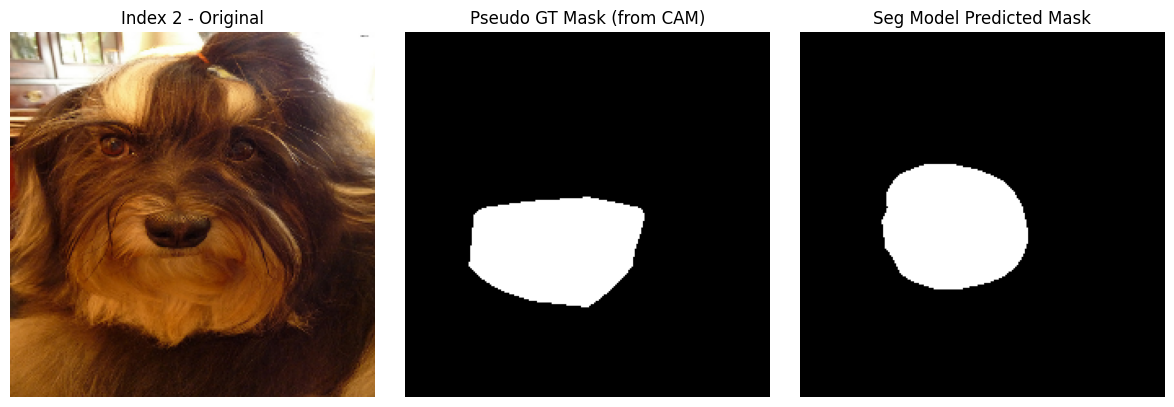

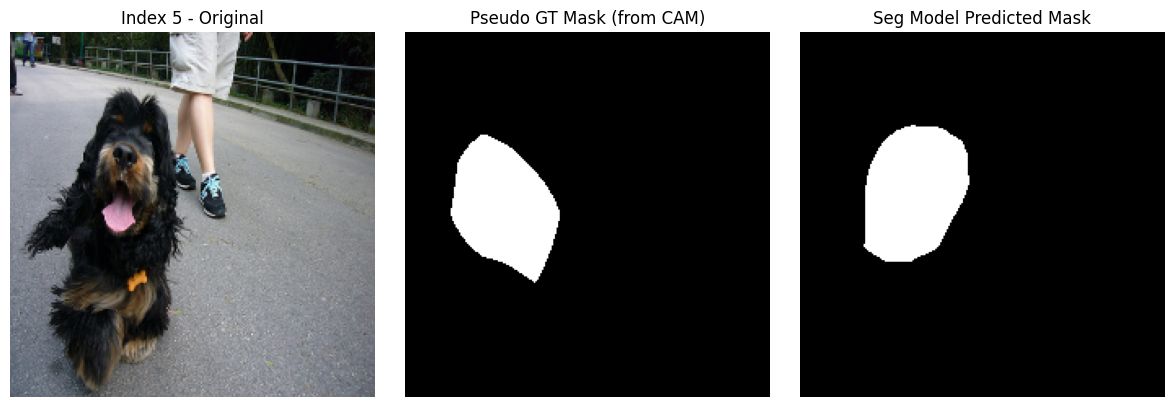

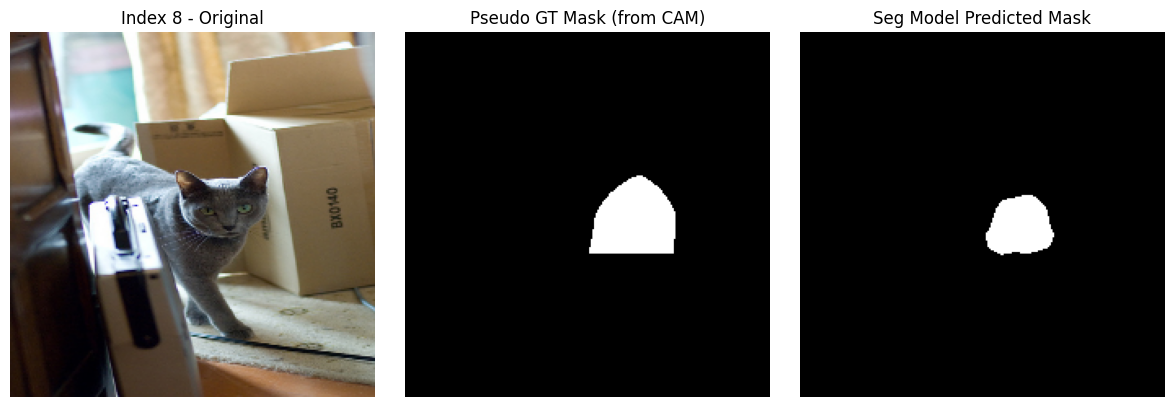

In [34]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def denormalize_image(image_tensor, mean, std):
    """
    image_tensor: a PyTorch tensor of shape [C,H,W], normalized by 'mean' and 'std'
    mean, std: tuples/lists of length C (e.g. (0.485, 0.456, 0.406))

    Returns a [C,H,W] tensor in the [0..1] range that can be displayed with plt.imshow.
    """
    # Make a copy so we don't modify the original
    image_clone = image_tensor.clone().detach()
    for c in range(image_clone.shape[0]):
        image_clone[c] = image_clone[c] * std[c] + mean[c]
    # Clamp to [0,1] to avoid any out-of-bounds
    image_clone = torch.clamp(image_clone, 0, 1)
    return image_clone


def visualize_segmentation_side_by_side(
    seg_model,
    seg_val_ds,  # A Dataset that returns (image_tensor, mask_tensor)
    device,
    mean=(0.485, 0.456, 0.406),
    std=(0.229, 0.224, 0.225),
    indices_to_show=[0,1,2]
):
    """
    - seg_model: trained segmentation model (e.g. DeepLab) in eval mode
    - seg_val_ds: dataset returning (image_tensor, mask_tensor)
    - device: "cuda" or "cpu"
    - mean, std: used for denormalizing the image
    - indices_to_show: which dataset indices to visualize
    """
    seg_model.eval()

    for idx in indices_to_show:
        # 1) Grab one sample (image & ground truth) from the dataset
        image_tensor, gt_mask_tensor = seg_val_ds[idx]
        # image_tensor: [C,H,W], already normalized
        # gt_mask_tensor: [H,W] in {0,1} (binary) or [0..N-1] (multi-class)

        # 2) Move image to device and do inference
        input_batch = image_tensor.unsqueeze(0).to(device)  # shape [1,C,H,W]

        with torch.no_grad():
            output = seg_model(input_batch)['out']  # shape [1, num_classes, H, W]

        preds = torch.argmax(output, dim=1)  # shape [1,H,W]
        pred_mask = preds.squeeze(0).cpu().numpy().astype(np.uint8)  # shape [H,W]

        # 3) De-normalize the image for display
        #    We'll convert [C,H,W] -> [H,W,C] after de-normalizing.
        denorm_image = denormalize_image(image_tensor, mean, std)  # still [C,H,W]
        denorm_image_np = denorm_image.permute(1,2,0).cpu().numpy()  # [H,W,C] in [0..1]

        # Ground truth mask
        gt_mask_np = gt_mask_tensor.cpu().numpy()

        # 4) Plot them side by side in subplots
        fig, axes = plt.subplots(1, 3, figsize=(12, 4))

        # Original image
        axes[0].imshow(denorm_image_np)
        axes[0].set_title(f"Index {idx} - Original")
        axes[0].axis("off")

        # Ground truth mask
        axes[1].imshow(gt_mask_np, cmap="gray")
        axes[1].set_title("Pseudo GT Mask (from CAM)")
        axes[1].axis("off")

        # Predicted mask
        axes[2].imshow(pred_mask, cmap="gray")
        axes[2].set_title("Seg Model Predicted Mask")
        axes[2].axis("off")

        plt.tight_layout()
        plt.show()

# Assume you have:
# seg_val_ds = PseudoSegDataset(...) or your actual val dataset returning (img, mask)
# seg_model = a trained segmentation model
# loaded: seg_model.load_state_dict(torch.load("seg_model.pth")) etc.
# seg_model.to(device)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Suppose you want to visualize indices 0, 1, and 2 from the val dataset
visualize_segmentation_side_by_side(
    seg_model=seg_model,
    seg_val_ds=seg_val_ds,
    device=device,
    mean=(0.485, 0.456, 0.406),  # typical ImageNet
    std=(0.229, 0.224, 0.225),
    indices_to_show=[2, 5, 8]    # pick any indices you like
)

In [ ]:
    # 4. Apply ReCAM refinement
    refine_cams_with_recam("cams_out", refined_dir="cams_refined",
                           threshold=0.3, expansion_factor=1.2)


ReCAM refinement complete!


In [ ]:
# 5. Generate pseudo masks
generate_pseudo_masks(refined_cam_dir="cams_refined",
                      output_mask_dir="pseudo_masks",
                      threshold=0.5)

Pseudo-label generation complete!


In [ ]:
import os

lst_1 = os.listdir("/content/cams_out") # your directory path
print(len(lst_1)) # number of files

lst_2 = os.listdir("/content/cams_refined") # your directory path
print(len(lst_2)) # number of files

lst_2 = os.listdir("/content/pseudo_masks") # your directory path
print(len(lst_2)) # number of files

3671
3671
3671


In [ ]:
!zip -r cams_out.zip /content/cams_out/

  adding: content/cams_out/ (stored 0%)
  adding: content/cams_out/cam_901.npy (deflated 34%)
  adding: content/cams_out/cam_1762.npy (deflated 35%)
  adding: content/cams_out/cam_2748.npy (deflated 34%)
  adding: content/cams_out/cam_3557.npy (deflated 37%)
  adding: content/cams_out/cam_1633.npy (deflated 51%)
  adding: content/cams_out/cam_2663.npy (deflated 34%)
  adding: content/cams_out/cam_3665.npy (deflated 42%)
  adding: content/cams_out/cam_1608.npy (deflated 36%)
  adding: content/cams_out/cam_3553.npy (deflated 39%)
  adding: content/cams_out/cam_3449.npy (deflated 49%)
  adding: content/cams_out/cam_3016.npy (deflated 35%)
  adding: content/cams_out/cam_2224.npy (deflated 43%)
  adding: content/cams_out/cam_268.npy (deflated 35%)
  adding: content/cams_out/cam_755.npy (deflated 41%)
  adding: content/cams_out/cam_733.npy (deflated 34%)
  adding: content/cams_out/cam_747.npy (deflated 32%)
  adding: content/cams_out/cam_2545.npy (deflated 33%)
  adding: content/cams_out/cam

In [ ]:
!zip -r cams_refined.zip /content/cams_refined

updating: content/cams_refined/ (stored 0%)
updating: content/cams_refined/cam_901.npy (deflated 34%)
updating: content/cams_refined/cam_1762.npy (deflated 35%)
updating: content/cams_refined/cam_2748.npy (deflated 34%)
updating: content/cams_refined/cam_3557.npy (deflated 37%)
updating: content/cams_refined/cam_1633.npy (deflated 51%)
updating: content/cams_refined/cam_2663.npy (deflated 34%)
updating: content/cams_refined/cam_3665.npy (deflated 42%)
updating: content/cams_refined/cam_1608.npy (deflated 36%)
updating: content/cams_refined/cam_3553.npy (deflated 40%)
updating: content/cams_refined/cam_3449.npy (deflated 49%)
updating: content/cams_refined/cam_3016.npy (deflated 35%)
updating: content/cams_refined/cam_2224.npy (deflated 43%)
updating: content/cams_refined/cam_268.npy (deflated 35%)
updating: content/cams_refined/cam_755.npy (deflated 41%)
updating: content/cams_refined/cam_733.npy (deflated 34%)
updating: content/cams_refined/cam_747.npy (deflated 32%)
updating: content

In [ ]:
!zip -r pseudo_masks.zip /content/pseudo_masks

  adding: content/pseudo_masks/ (stored 0%)
  adding: content/pseudo_masks/cam_485.png (deflated 45%)
  adding: content/pseudo_masks/cam_2695.png (deflated 32%)
  adding: content/pseudo_masks/cam_3607.png (deflated 19%)
  adding: content/pseudo_masks/cam_196.png (deflated 35%)
  adding: content/pseudo_masks/cam_1559.png (deflated 36%)
  adding: content/pseudo_masks/cam_2078.png (deflated 32%)
  adding: content/pseudo_masks/cam_2525.png (deflated 25%)
  adding: content/pseudo_masks/cam_3155.png (deflated 53%)
  adding: content/pseudo_masks/cam_302.png (deflated 47%)
  adding: content/pseudo_masks/cam_3157.png (deflated 22%)
  adding: content/pseudo_masks/cam_591.png (deflated 38%)
  adding: content/pseudo_masks/cam_3314.png (deflated 38%)
  adding: content/pseudo_masks/cam_815.png (deflated 38%)
  adding: content/pseudo_masks/cam_3440.png (deflated 20%)
  adding: content/pseudo_masks/cam_1256.png (deflated 25%)
  adding: content/pseudo_masks/cam_3642.png (deflated 27%)
  adding: content